![alt text](title.png)

# Models(8) : 7 single modles 1 ensemble

## Models are splitted as two types: Region & Age base model and Age & Sex base model
>A.K.A. RA model and AS model

>I separated dataset by RA and AS criteria. 
RA_train, RA_test, AS_train, and AS_test datasets are created.
Target is the **"avg_score".**

>5 fold CV with shuffle. 

> Bayesian Optimization parameter search 2 initial points and 50 iterations.

> LGBM Only

### No.1 Diff model
I grouped variables by certain criteria such as amount, balance, and payments.
Then, I have 9 groups of variables to create new features in Diff Model.
And simply I make sum of those variables by each groups. Then, I subtracted and added each of them. But didn't make multiplication.
As a result, 28 of new columns are added to the dataset to train.
#### Result
![alt text](diff_model.png)
### No.2 Chg model
I made lag features. 1 to 6 months lag features are generated. And gap of lag features are also made.
#### Result
![alt text](chg_model.png)
### No.3 Rng model
Comparison within the same city and the same month.
Like comparing L011's January's values with L021's Jan values.
Only comparing groups in the same city.
Values are made up of 5 types: sum-value, abs(mean-value), abs(max-value), abs(min-value), and rank.
#### Result
![alt text](rgn_model.png)
> This is weired since only this AS_model's rmse is smaller than RA_model with this Rng feature model.
### No.4 Type model
Simply divide variables whether its name has loan or credit.
and I made sum within group.
#### Result
![alt text](type_model.png)
### No.5 Rnd1 model(ratios and diffs) top features
Basic ratios and differences between two variables with only top features from type model.
115 of new features were made.
#### Result
![alt text](rnd1_model.png)
### No.6 Rnd2 model(ratios and diffs) inclusion of the rest
Basic ratios and differences between two variables except top features and includes the rest of them.
109 of new features were made.
#### Result
![alt text](rnd2_model.png)
### No.7 Full model
From diff to rnd2, added every features in this model.
#### Result
![alt text](full_model.png)

# Visualization  Based on those features. 

In [6]:
import gc
import os
import time
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
path = "../Dacon_8th/"
file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith(".csv")]
print ("file_list_csv: {}".format(file_list_csv))

file_list_csv: ['AS_FULL_V1_best_features.csv', 'AS_FULL_V1_oof_lgb.csv', 'AS_FULL_V1_predictions_lgb.csv', 'AS_notop3_oof_lgb.csv', 'AS_notop3_predictions_lgb.csv', 'AS_oof_lgb.csv', 'AS_predictions_lgb.csv', 'AS_V10_oof_lgb.csv', 'AS_V10_predictions_lgb.csv', 'AS_V11_best_features.csv', 'AS_V11_oof_lgb.csv', 'AS_V11_predictions_lgb.csv', 'AS_V12_best_features.csv', 'AS_V12_oof_lgb.csv', 'AS_V12_predictions_lgb.csv', 'AS_V13_best_features.csv', 'AS_V13_oof_lgb.csv', 'AS_V13_predictions_lgb.csv', 'AS_V6_oof_lgb.csv', 'AS_V6_predictions_lgb.csv', 'AS_V7_oof_lgb.csv', 'AS_V7_predictions_lgb.csv', 'AS_V8_oof_lgb.csv', 'AS_V8_predictions_lgb.csv', 'AS_V9_oof_lgb.csv', 'AS_V9_predictions_lgb.csv', 'credit_card_data.csv', 'D8_FULL_V1_AS_test.csv', 'D8_FULL_V1_AS_train.csv', 'D8_FULL_V1_RA_test.csv', 'D8_FULL_V1_RA_train.csv', 'dacon8_df.csv', 'jeju_financial_life_data.csv', 'minmaxscaled_oof_lgb.csv', 'minmaxscaled_predictions_lgb.csv', 'oof_lgb.csv', 'predictions_lgb.csv', 'RA_FULL_V1_best_

In [7]:
DF = pd.read_csv("../Dacon_8th/credit_card_data.csv")
RA_train = pd.read_csv("../Dacon_8th/D8_FULL_V1_RA_train.csv")
RA_test = pd.read_csv("../Dacon_8th/D8_FULL_V1_RA_test.csv")
AS_train = pd.read_csv("../Dacon_8th/D8_FULL_V1_AS_train.csv")
AS_test = pd.read_csv("../Dacon_8th/D8_FULL_V1_AS_test.csv")

In [8]:
pd.set_option("display.max_columns", 500)

## Distribution

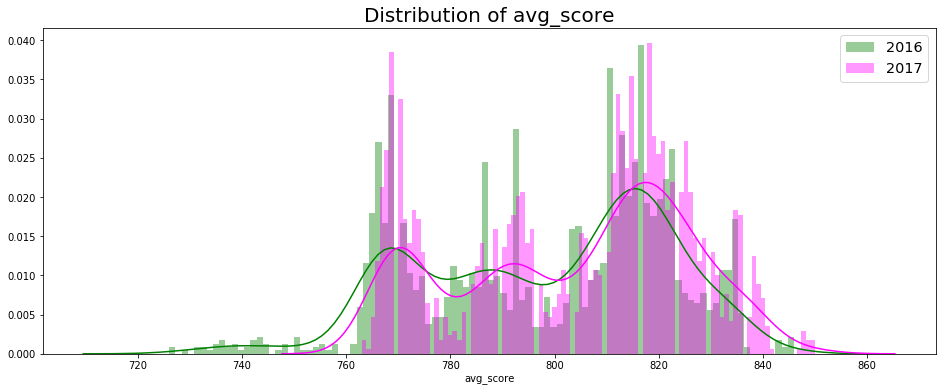

In [9]:
plt.figure(figsize=(16,6))
plt.title("Distribution of avg_score", fontsize=20)
sns.distplot(DF[DF['year']==2016]['avg_score'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['avg_score'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

#### 3 peaks are noticeable, and those are closely related to actual Credit Rating.

#### Else?

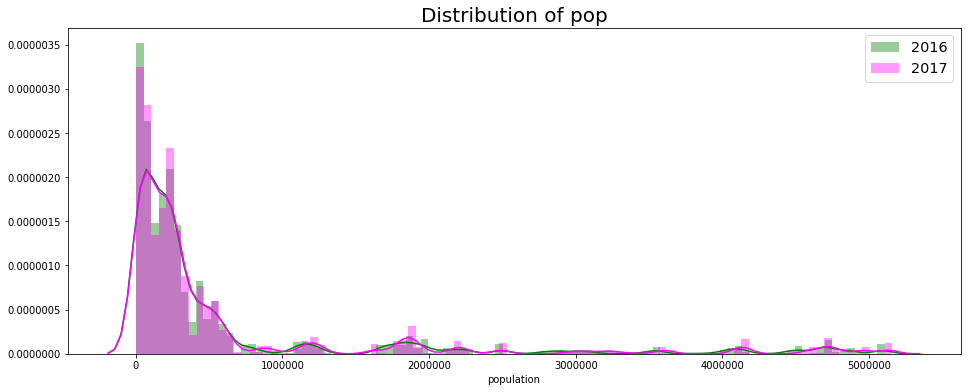

In [10]:
plt.figure(figsize=(16,6))
plt.title("Distribution of pop", fontsize=20)
sns.distplot(DF[DF['year']==2016]['population'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['population'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

#### right skewed
#### what are the features of those concentrated counts?

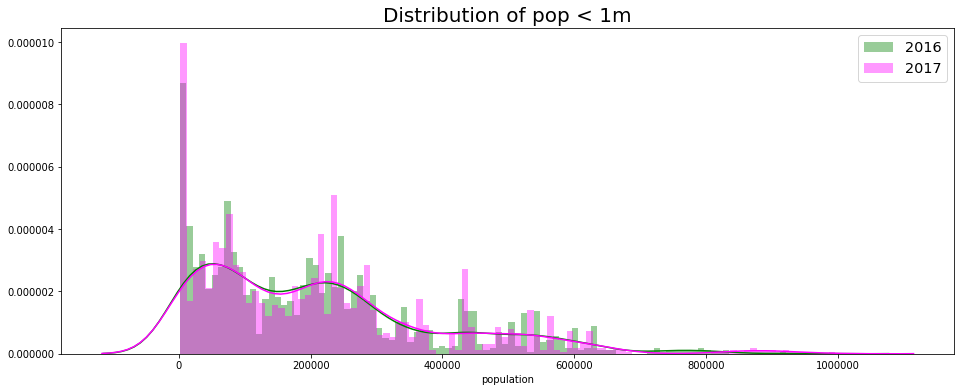

In [11]:
plt.figure(figsize=(16,6))
plt.title("Distribution of pop < 1m", fontsize=20)
sns.distplot(DF[(DF['year']==2016)&(DF['population'] < 1000000)]['population'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[(DF['year']==2017)&(DF['population'] < 1000000)]['population'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

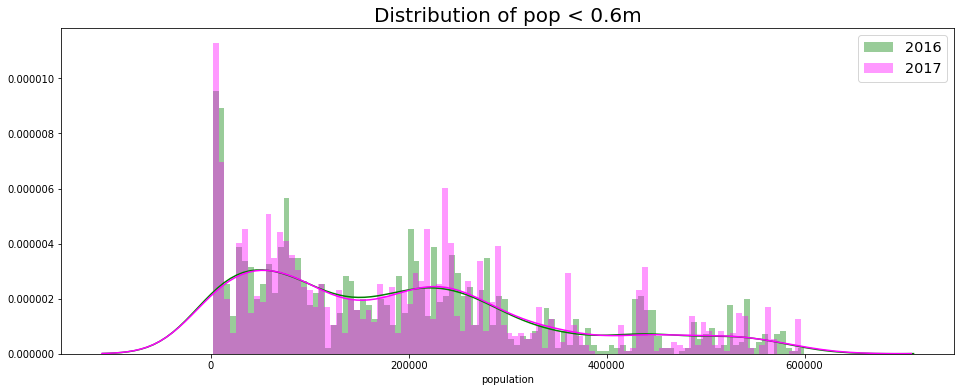

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of pop < 0.6m", fontsize=20)
sns.distplot(DF[(DF['year']==2016)&(DF['population'] < 600000)]['population'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[(DF['year']==2017)&(DF['population'] < 600000)]['population'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

#### Two peaks

In [13]:
pop_sk_50 = DF[(DF['population']>0)&(DF['population']<150000)]
pop_sk_250 = DF[(DF['population']>150000)&(DF['population']<300000)]

In [14]:
DF['avg_score'].mean(), DF['avg_rat'].mean()

(801.2973251028807, 3.246913580246914)

In [15]:
pop_sk_50.avg_score.mean(), pop_sk_50.avg_rat.mean()

(804.2952836637047, 3.2330827067669174)

In [16]:
pop_sk_250.avg_score.mean(), pop_sk_250.avg_rat.mean()

(800.0313075506446, 3.231123388581952)

In [17]:
pop_sk_50.city.value_counts().head()

제주    216
울산    121
광주    120
대전    104
충북     97
Name: city, dtype: int64

In [18]:
pop_sk_250.city.value_counts()

전남    133
전북    120
강원    120
충북    118
대전    110
광주     96
울산     95
충남     48
대구     48
경북     35
서울     24
경기     24
부산     24
경남     24
인천     22
Name: city, dtype: int64

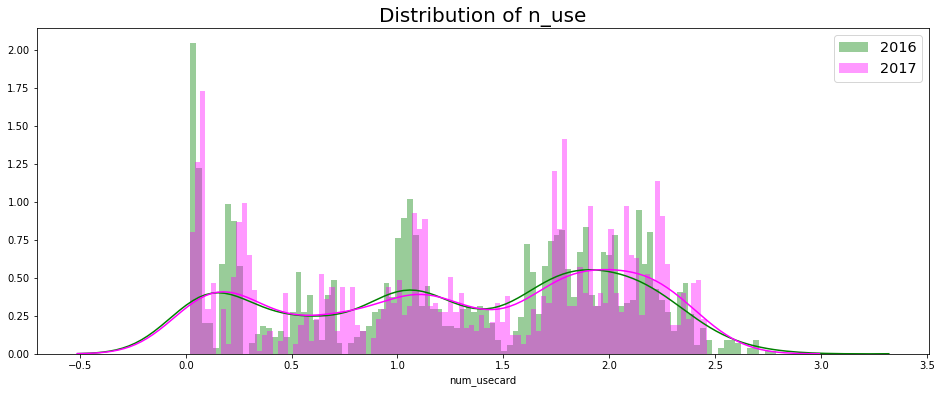

In [19]:
plt.figure(figsize=(16,6))
plt.title("Distribution of n_use", fontsize=20)
sns.distplot(DF[DF['year']==2016]['num_usecard'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['num_usecard'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

> 3 peaks

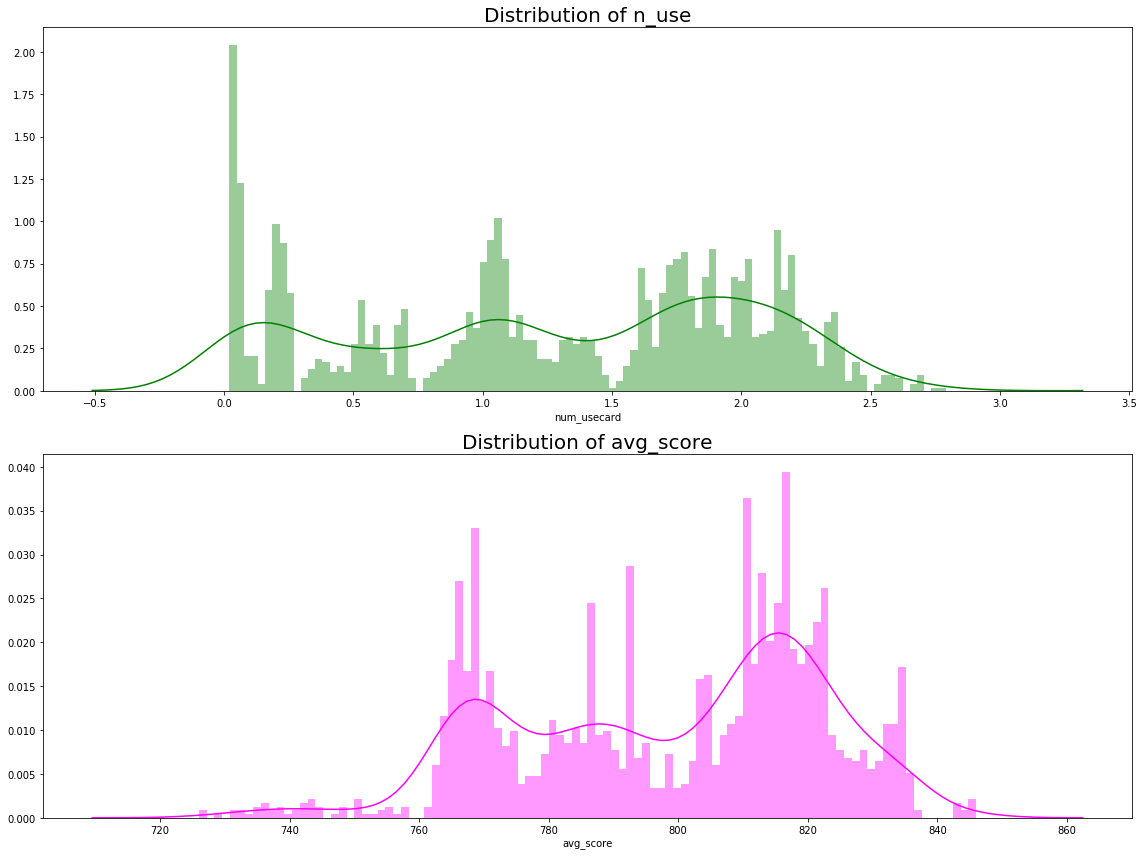

In [20]:
# compare avg_score and num_use_card
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.title("Distribution of n_use", fontsize=20)
sns.distplot(DF[DF['year']==2016]['num_usecard'],color="green", kde=True,bins=100)
plt.subplot(2,1,2)
plt.title("Distribution of avg_score", fontsize=20)
sns.distplot(DF[DF['year']==2016]['avg_score'],color="magenta", kde=True,bins=100)
plt.tight_layout()
plt.show()

> looks similar..

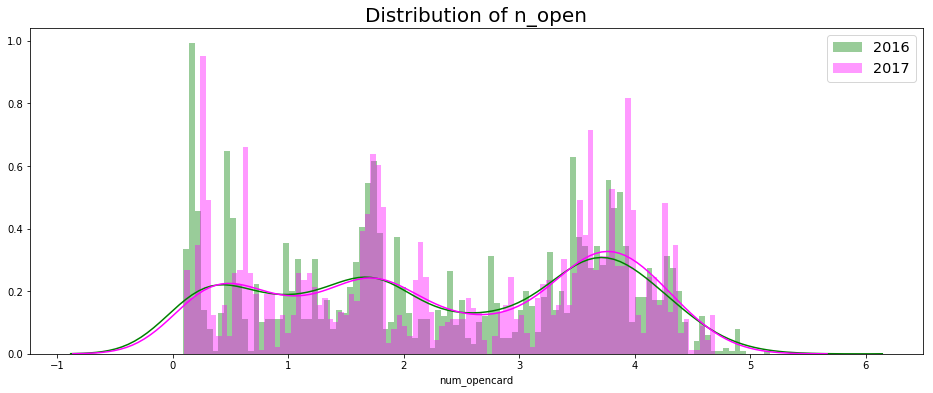

In [21]:
from matplotlib import colors as mcolors
plt.figure(figsize=(16,6))
plt.title("Distribution of n_open", fontsize=20)
sns.distplot(DF[DF['year']==2016]['num_opencard'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['num_opencard'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

> 3peaks

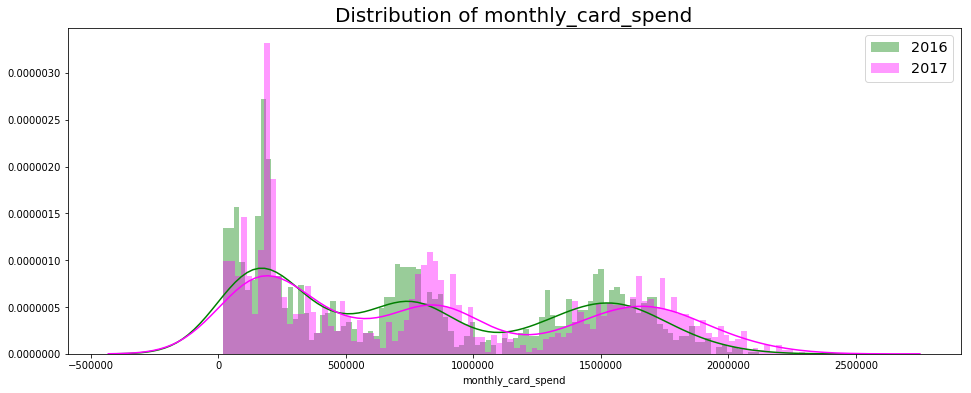

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of monthly_card_spend", fontsize=20)
sns.distplot(DF[DF['year']==2016]['monthly_card_spend'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['monthly_card_spend'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

# Since there is high probablity of having 3 peaks from many variables.

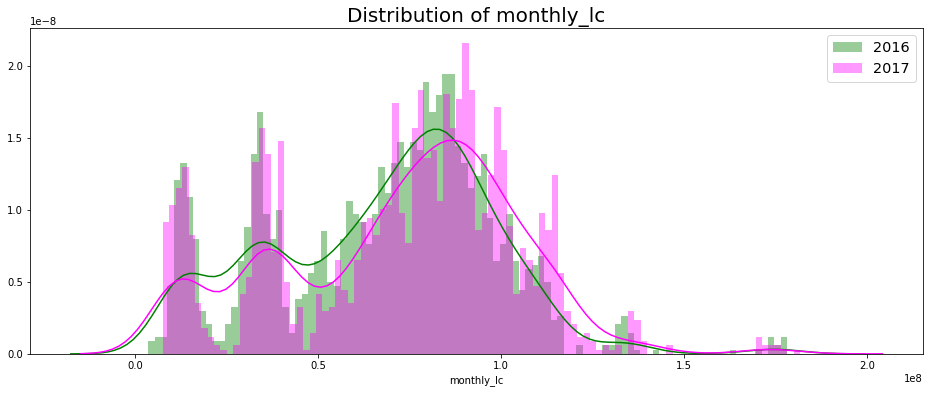

In [23]:
plt.figure(figsize=(16,6))
plt.title("Distribution of monthly_lc", fontsize=20)
sns.distplot(DF[DF['year']==2016]['monthly_lc'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['monthly_lc'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

#### 3ps...

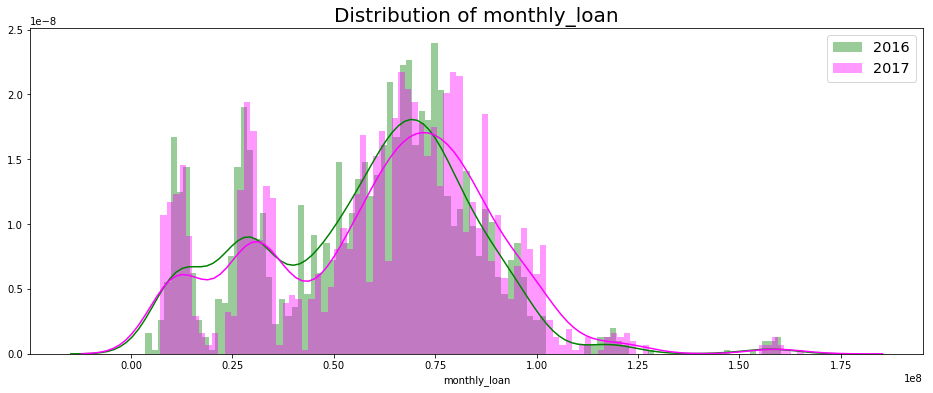

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of monthly_loan", fontsize=20)
sns.distplot(DF[DF['year']==2016]['monthly_loan'],color="green", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['monthly_loan'],color="magenta", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

# 3peaks check by avg_rat

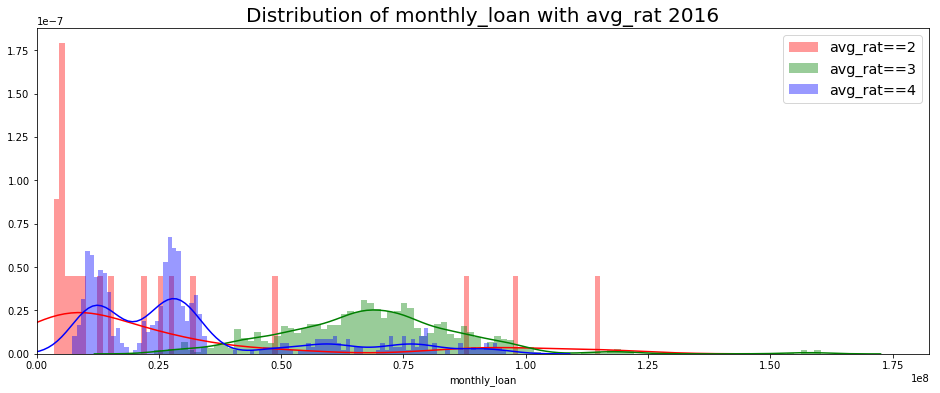

In [25]:
plt.figure(figsize=(16,6))
plt.title("Distribution of monthly_loan with avg_rat 2016", fontsize=20)
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==2)]['monthly_loan'],color="r", kde=True,bins=100, label='avg_rat==2')
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==3)]['monthly_loan'],color="g", kde=True,bins=100, label='avg_rat==3')
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==4)]['monthly_loan'],color="b", kde=True,bins=100, label='avg_rat==4')
plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

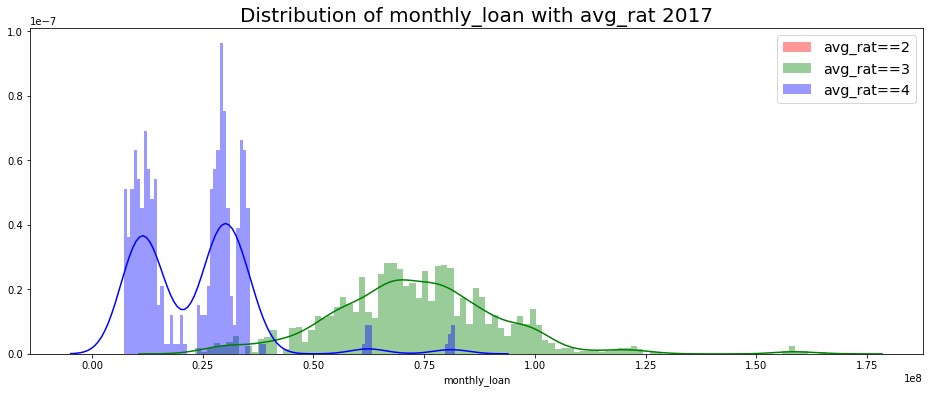

In [26]:
plt.figure(figsize=(16,6))
plt.title("Distribution of monthly_loan with avg_rat 2017", fontsize=20)
sns.distplot(DF[(DF['year']==2017)&(DF['avg_rat']==2)]['monthly_loan'],color="r", kde=True,bins=100, label='avg_rat==2')
sns.distplot(DF[(DF['year']==2017)&(DF['avg_rat']==3)]['monthly_loan'],color="g", kde=True,bins=100, label='avg_rat==3')
sns.distplot(DF[(DF['year']==2017)&(DF['avg_rat']==4)]['monthly_loan'],color="b", kde=True,bins=100, label='avg_rat==4')
#plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

In [27]:
DF[DF['year']==2016]['avg_rat'].value_counts()

3    1389
4     535
2      20
Name: avg_rat, dtype: int64

In [28]:
DF[DF['year']==2017]['avg_rat'].value_counts()

3    1499
4     445
Name: avg_rat, dtype: int64

# no rating 2 in 2017?????????

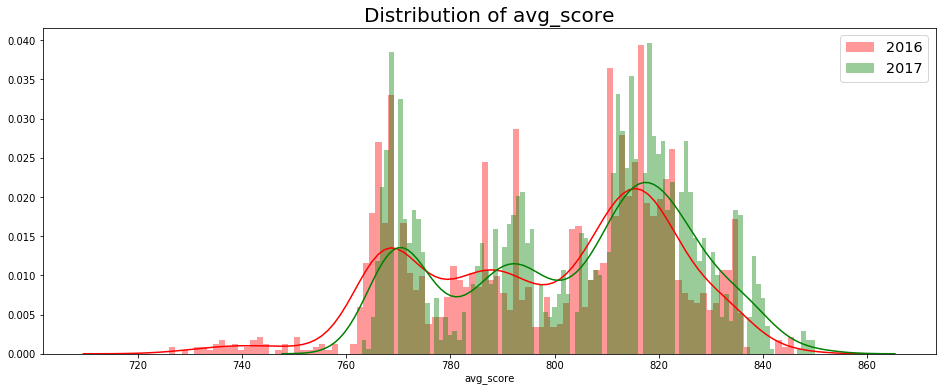

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of avg_score", fontsize=20)
sns.distplot(DF[DF['year']==2016]['avg_score'],color="r", kde=True,bins=100, label='2016')
sns.distplot(DF[DF['year']==2017]['avg_score'],color="g", kde=True,bins=100, label='2017')
plt.legend(fontsize='x-large')
plt.show()

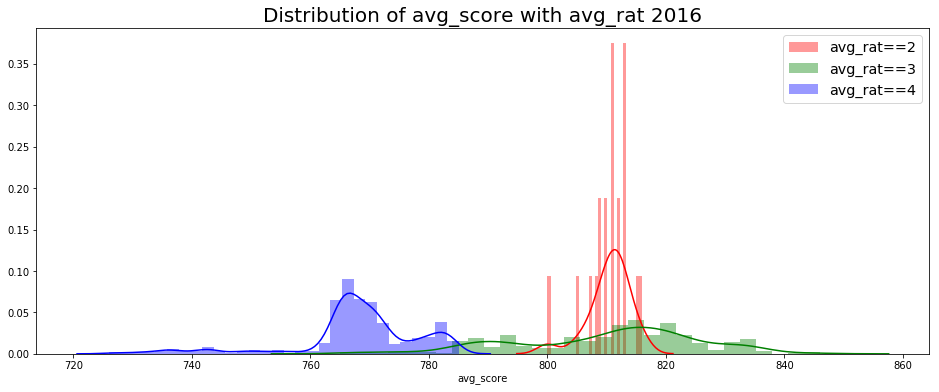

In [35]:
plt.figure(figsize=(16,6))
plt.title("Distribution of avg_score with avg_rat 2016", fontsize=20)
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==2)]['avg_score'],color="r", kde=True,bins=30, label='avg_rat==2')
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==3)]['avg_score'],color="g", kde=True,bins=30, label='avg_rat==3')
sns.distplot(DF[(DF['year']==2016)&(DF['avg_rat']==4)]['avg_score'],color="b", kde=True,bins=30, label='avg_rat==4')
plt.legend(fontsize='x-large')
plt.show()

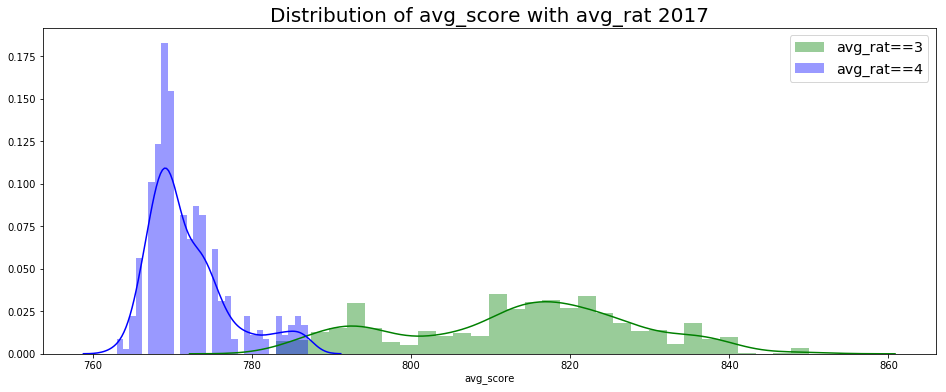

In [34]:
plt.figure(figsize=(16,6))
plt.title("Distribution of avg_score with avg_rat 2017", fontsize=20)
sns.distplot(DF[(DF['year']==2017)&(DF['avg_rat']==3)]['avg_score'],color="g", kde=True,bins=30, label='avg_rat==3')
sns.distplot(DF[(DF['year']==2017)&(DF['avg_rat']==4)]['avg_score'],color="b", kde=True,bins=30, label='avg_rat==4')
plt.legend(fontsize='x-large')
plt.show()

# 신용등급제에서 신용점수제로 변화함에 따라서 등급은 의미가 없어짐

# lets compare TOP No.1 features with avg_score from models
## Top No.1
> credit_card_installments_payment x2;num_usecard;loan_commitment;month x2;lag_1m_avg_score
### Top No.2
> monthly_installments_loan;ls_rep_loanb;population;credit_loan;creln_ratio_1 ('credit_card_installments_payment'/'credit_loan');credit_card_installments_payment;num_usecard

## credit_card_installments_payment

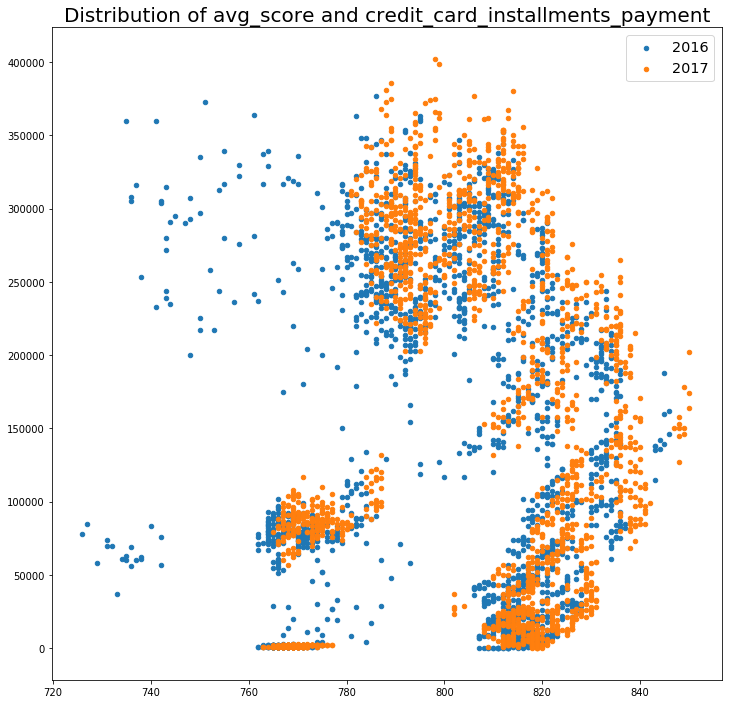

In [41]:
plt.figure(figsize=(12,12))
plt.title("Distribution of avg_score and credit_card_installments_payment", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[DF['year']==2016]['avg_score'],DF[DF['year']==2016]['credit_card_installments_payment'], label='2016', s=20)
plt.scatter(DF[DF['year']==2017]['avg_score'],DF[DF['year']==2017]['credit_card_installments_payment'], label='2017', s=20)
#plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

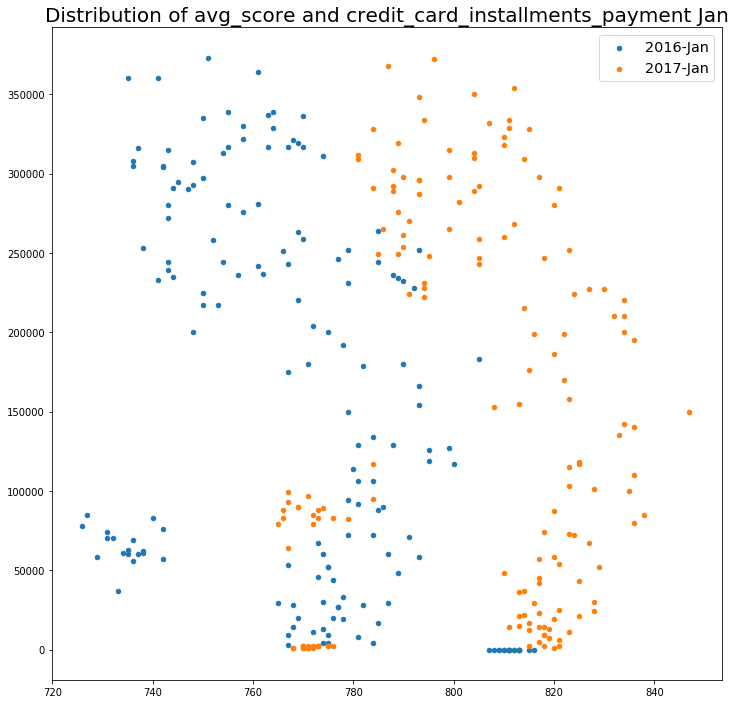

In [42]:
plt.figure(figsize=(12,12))
plt.title("Distribution of avg_score and credit_card_installments_payment Jan", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==1)]['credit_card_installments_payment'], label='2016-Jan', s=20)
plt.scatter(DF[(DF['year']==2017)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2017)&(DF['month']==1)]['credit_card_installments_payment'], label='2017-Jan', s=20)
#plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

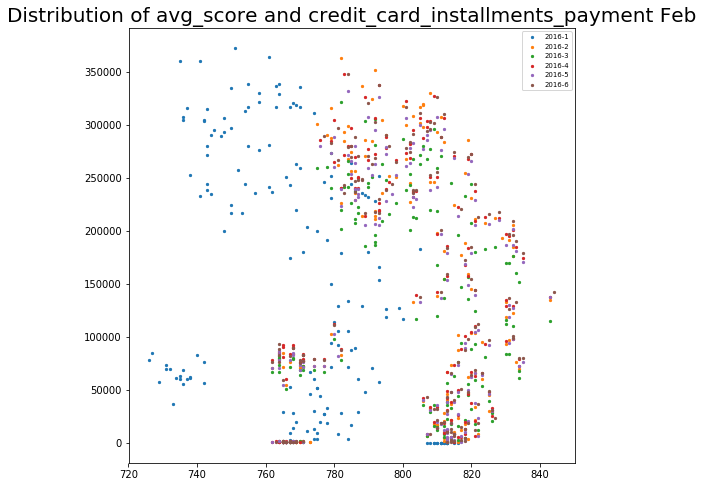

In [43]:
plt.figure(figsize=(8,8))
plt.title("Distribution of avg_score and credit_card_installments_payment Feb", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==1)]['credit_card_installments_payment'], label='2016-1', s=5)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==2)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==2)]['credit_card_installments_payment'], label='2016-2', s=5)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==3)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==3)]['credit_card_installments_payment'], label='2016-3', s=5)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==4)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==4)]['credit_card_installments_payment'], label='2016-4', s=5)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==5)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==5)]['credit_card_installments_payment'], label='2016-5', s=5)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==6)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==6)]['credit_card_installments_payment'], label='2016-6', s=5)
#plt.xlim(0, )
plt.legend(fontsize='x-small')
plt.show()

## num_usecard

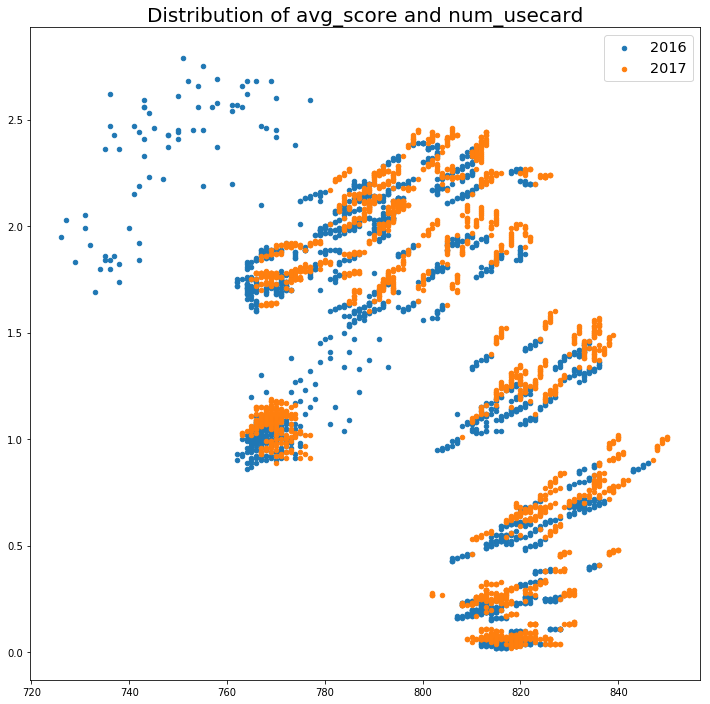

In [44]:
plt.figure(figsize=(12,12))
plt.title("Distribution of avg_score and num_usecard", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[DF['year']==2016]['avg_score'],DF[DF['year']==2016]['num_usecard'], label='2016', s=20)
plt.scatter(DF[DF['year']==2017]['avg_score'],DF[DF['year']==2017]['num_usecard'], label='2017', s=20)
#plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

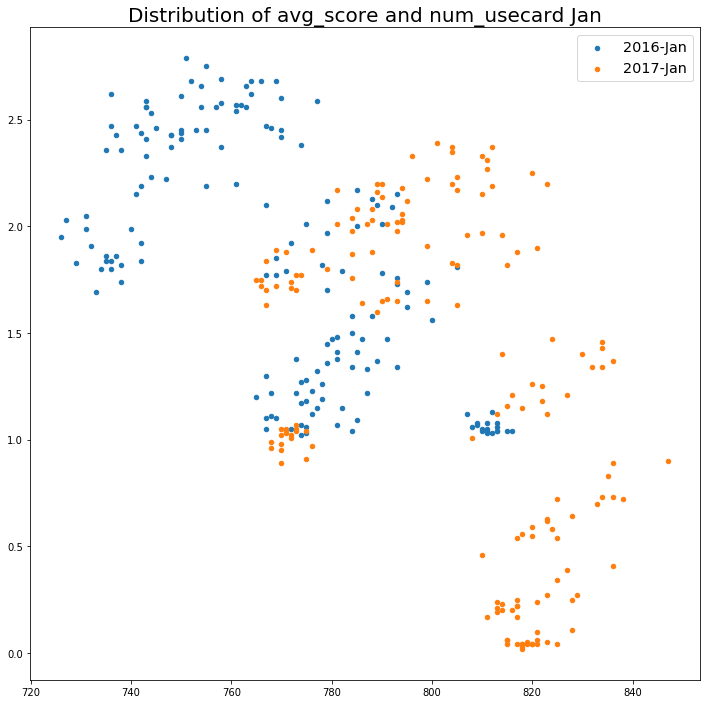

In [45]:
plt.figure(figsize=(12,12))
plt.title("Distribution of avg_score and num_usecard Jan", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==1)]['num_usecard'], label='2016-Jan', s=20)
plt.scatter(DF[(DF['year']==2017)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2017)&(DF['month']==1)]['num_usecard'], label='2017-Jan', s=20)
#plt.xlim(0, )
plt.legend(fontsize='x-large')
plt.show()

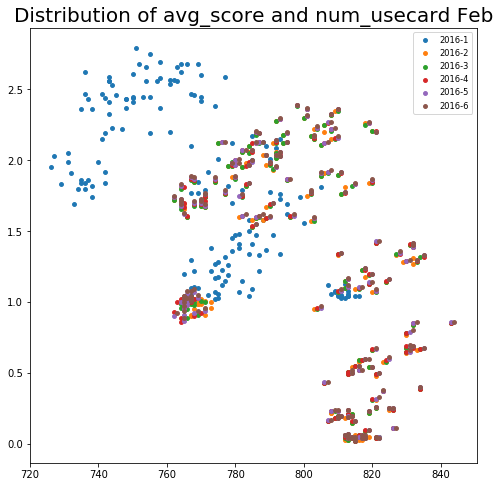

In [46]:
plt.figure(figsize=(8,8))
plt.title("Distribution of avg_score and num_usecard Feb", fontsize=20)
#plt.subplot(5,1,1)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==1)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==1)]['num_usecard'], label='2016-1', s=15)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==2)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==2)]['num_usecard'], label='2016-2', s=15)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==3)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==3)]['num_usecard'], label='2016-3', s=15)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==4)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==4)]['num_usecard'], label='2016-4', s=15)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==5)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==5)]['num_usecard'], label='2016-5', s=15)
plt.scatter(DF[(DF['year']==2016)&(DF['month']==6)]['avg_score'],\
            DF[(DF['year']==2016)&(DF['month']==6)]['num_usecard'], label='2016-6', s=15)
#plt.xlim(0, )
plt.legend(fontsize='small')
plt.show()

# BOKEH

In [47]:
from bokeh.palettes import Paired12
from bokeh.plotting import figure, output_file, show
# make bokeh display figures inside the notebook
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [48]:
BS_16_mean = DF[(DF['city']=="부산")&(DF['year']==2016)].groupby(['month']).mean().reset_index()
GG_16_mean = DF[(DF['city']=="경기")&(DF['year']==2016)].groupby(['month']).mean().reset_index()
SO_16_mean = DF[(DF['city']=="서울")&(DF['year']==2016)].groupby(['month']).mean().reset_index()
DJ_16_mean = DF[(DF['city']=="대전")&(DF['year']==2016)].groupby(['month']).mean().reset_index()

BS_17_mean = DF[(DF['city']=="부산")&(DF['year']==2017)].groupby(['month']).mean().reset_index()
GG_17_mean = DF[(DF['city']=="경기")&(DF['year']==2017)].groupby(['month']).mean().reset_index()
SO_17_mean = DF[(DF['city']=="서울")&(DF['year']==2017)].groupby(['month']).mean().reset_index()
DJ_17_mean = DF[(DF['city']=="대전")&(DF['year']==2017)].groupby(['month']).mean().reset_index()

In [50]:
p = figure(plot_width=800, plot_height=500)
p.title.text = 'Credit score and credit_card_installments_payment by month and region'

p.circle(BS_16_mean['month'], BS_16_mean['avg_score'], color="cadetblue", line_width=2, alpha=0.3, size=10, legend="Busan16")
p.circle(GG_16_mean['month'], GG_16_mean['avg_score'], color="fuchsia", line_width=2, alpha=0.3, size=10, legend="GG16")
p.circle(SO_16_mean['month'], SO_16_mean['avg_score'], color="olivedrab", line_width=2, alpha=0.3, size=10, legend="Seoul16")
p.circle(DJ_16_mean['month'], DJ_16_mean['avg_score'], color="purple", line_width=2, alpha=0.3, size=10, legend="Daejeon16")
p.circle(BS_17_mean['month'], BS_17_mean['avg_score'], color="cadetblue", line_width=2, alpha=0.3, size=10, legend="Busan17")
p.circle(GG_17_mean['month'], GG_17_mean['avg_score'], color="fuchsia", line_width=2, alpha=0.3, size=10, legend="GG17")
p.circle(SO_17_mean['month'], SO_17_mean['avg_score'], color="olivedrab", line_width=2, alpha=0.3, size=10, legend="Seoul17")
p.circle(DJ_17_mean['month'], DJ_17_mean['avg_score'], color="purple", line_width=2, alpha=0.3, size=10, legend="Daejeon17")

p.legend.location = "bottom_right"

p.legend.click_policy="hide"

#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")

show(p)

In [51]:
p = figure(plot_width=800, plot_height=500)
p.title.text = 'Credit score and credit_card_installments_payment by month and region'

p.circle(BS_17_mean['month'], BS_17_mean['avg_score'], color="cadetblue", line_width=2, alpha=0.3, size=10, legend="Busan17")
p.circle(GG_17_mean['month'], GG_17_mean['avg_score'], color="fuchsia", line_width=2, alpha=0.3, size=10, legend="GG17")
p.circle(SO_17_mean['month'], SO_17_mean['avg_score'], color="olivedrab", line_width=2, alpha=0.3, size=10, legend="Seoul17")
p.circle(DJ_17_mean['month'], DJ_17_mean['avg_score'], color="purple", line_width=2, alpha=0.3, size=10, legend="Daejeon17")

p.legend.location = "bottom_right"

p.legend.click_policy="hide"

#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")

show(p)

In [52]:
p = figure(plot_width=800, plot_height=500)
p.title.text = 'Credit score and credit_card_installments_payment by month and region'

p.circle(BS_17_mean['avg_score'], BS_17_mean['credit_card_installments_payment'], color="orangered", line_width=2, alpha=0.7, size=10, legend="Busan17")
p.circle(GG_17_mean['avg_score'], GG_17_mean['credit_card_installments_payment'], color="fuchsia", line_width=2, alpha=0.7, size=10, legend="GG17")
p.circle(SO_17_mean['avg_score'], SO_17_mean['credit_card_installments_payment'], color="cyan", line_width=2, alpha=0.7, size=10, legend="Seoul17")
p.circle(DJ_17_mean['avg_score'], DJ_17_mean['credit_card_installments_payment'], color="lime", line_width=2, alpha=0.7, size=10, legend="Daejeon17")

p.legend.location = "bottom_right"

p.legend.click_policy="hide"

#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")

show(p)

# We can see Linearity from above figure.

In [53]:
p = figure(plot_width=800, plot_height=500, x_axis_label="avg_score", y_axis_label="credit_card_installments_payment")
p.title.text = 'credit_card_installments_payment'

p.circle(DF['avg_score'], DF['credit_card_installments_payment'], color="orangered",  alpha=0.1, size=10, legend="ccip")
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")
show(p)

In [54]:
p = figure(plot_width=800, plot_height=500, x_axis_label="avg_score", y_axis_label="num_usecard")
p.title.text = 'num_usecard'

p.circle(DF['avg_score'], DF['num_usecard'], color="orangered", line_width=2, alpha=0.1, size=10, legend="ccip")
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")
show(p)

# Grouping??
## range from 760 to 780 many points are concentrated..as Zeros

# Let's check what those values are.

## Would these groups are effected by year?

In [55]:
p = figure(plot_width=800, plot_height=500, x_axis_label="avg_score", y_axis_label="credit_card_installments_payment")
p.title.text = 'credit_card_installments_payment 2016'

p.circle(DF[DF['year']==2016]['avg_score'], DF[DF['year']==2016]['credit_card_installments_payment'], color="orangered",  alpha=0.1, size=10, legend="ccip")
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")
show(p)

In [56]:
p = figure(plot_width=800, plot_height=500, x_axis_label="avg_score", y_axis_label="credit_card_installments_payment")
p.title.text = 'credit_card_installments_payment 2017'

p.circle(DF[DF['year']==2017]['avg_score'], DF[DF['year']==2017]['credit_card_installments_payment'], color="magenta",  alpha=0.1, size=10, legend="ccip")
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")
show(p)

### Let's merge into one figure

In [57]:
p = figure(plot_width=800, plot_height=500, x_axis_label="avg_score", y_axis_label="credit_card_installments_payment")
p.title.text = 'credit_card_installments_payment 2016-2017'

p.circle(DF[DF['year']==2016]['avg_score'], DF[DF['year']==2016]['credit_card_installments_payment'], color="orangered",  alpha=0.1, size=10, legend="2016")
p.circle(DF[DF['year']==2017]['avg_score'], DF[DF['year']==2017]['credit_card_installments_payment'], color="magenta",  alpha=0.1, size=10, legend="2017")
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
#output_file("interactive_legend.html", \
#            title="interactive_legend.py example")
show(p)

# Probably, Frequency Encoding will be useful.

## CCIP with Regions.

In [58]:
p = figure(plot_width=1000, plot_height=800, x_axis_label="avg_score", y_axis_label="credit_card_installments_payment")
p.title.text = 'ccip 2016 Regions'

p.circle(DF[(DF['year']==2016)&(DF['city']=="충북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충북")]['credit_card_installments_payment'],\
         color="orangered",  alpha=0.3, size=10, legend="충북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전북")]['credit_card_installments_payment'],\
         color="springgreen",  alpha=0.3, size=10, legend="전북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전남")]['credit_card_installments_payment'],\
         color="steelblue",  alpha=0.3, size=10, legend="전남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="부산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="부산")]['credit_card_installments_payment'],\
         color="tan",  alpha=0.3, size=10, legend="부산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="울산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="울산")]['credit_card_installments_payment'],\
         color="teal",  alpha=0.3, size=10, legend="울산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="충남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충남")]['credit_card_installments_payment'],\
         color="tomato",  alpha=0.3, size=10, legend="충남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="광주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="광주")]['credit_card_installments_payment'],\
         color="turquoise",  alpha=0.3, size=10, legend="광주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경남")]['credit_card_installments_payment'],\
         color="violet",  alpha=0.3, size=10, legend="경남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="인천")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="인천")]['credit_card_installments_payment'],\
         color="yellow",  alpha=0.3, size=10, legend="인천")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대전")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대전")]['credit_card_installments_payment'],\
         color="yellowgreen",  alpha=0.3, size=10, legend="대전")
p.circle(DF[(DF['year']==2016)&(DF['city']=="서울")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="서울")]['credit_card_installments_payment'],\
         color="slateblue",  alpha=0.3, size=10, legend="서울")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대구")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대구")]['credit_card_installments_payment'],\
         color="skyblue",  alpha=0.3, size=10, legend="대구")
p.circle(DF[(DF['year']==2016)&(DF['city']=="강원")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="강원")]['credit_card_installments_payment'],\
         color="sienna",  alpha=0.3, size=10, legend="강원")
p.circle(DF[(DF['year']==2016)&(DF['city']=="제주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="제주")]['credit_card_installments_payment'],\
         color="salmon",  alpha=0.3, size=10, legend="제주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경기")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경기")]['credit_card_installments_payment'],\
         color="sandybrown",  alpha=0.3, size=10, legend="경기")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경북")]['credit_card_installments_payment'],\
         color="purple",  alpha=0.3, size=10, legend="경북")


p.legend.location = "bottom_right"
p.legend.click_policy="hide"
output_file("interactive_legend.html", \
            title="interactive_legend.py example")
show(p)

In [59]:
p = figure(plot_width=1000, plot_height=800, x_axis_label="avg_score", y_axis_label="num_usecard")
p.title.text = 'n_usecard 2016 Regions'

p.circle(DF[(DF['year']==2016)&(DF['city']=="충북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충북")]['num_usecard'],\
         color="orangered",  alpha=0.3, size=10, legend="충북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전북")]['num_usecard'],\
         color="springgreen",  alpha=0.3, size=10, legend="전북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전남")]['num_usecard'],\
         color="steelblue",  alpha=0.3, size=10, legend="전남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="부산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="부산")]['num_usecard'],\
         color="tan",  alpha=0.3, size=10, legend="부산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="울산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="울산")]['num_usecard'],\
         color="teal",  alpha=0.3, size=10, legend="울산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="충남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충남")]['num_usecard'],\
         color="tomato",  alpha=0.3, size=10, legend="충남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="광주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="광주")]['num_usecard'],\
         color="turquoise",  alpha=0.3, size=10, legend="광주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경남")]['num_usecard'],\
         color="violet",  alpha=0.3, size=10, legend="경남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="인천")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="인천")]['num_usecard'],\
         color="yellow",  alpha=0.3, size=10, legend="인천")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대전")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대전")]['num_usecard'],\
         color="yellowgreen",  alpha=0.3, size=10, legend="대전")
p.circle(DF[(DF['year']==2016)&(DF['city']=="서울")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="서울")]['num_usecard'],\
         color="slateblue",  alpha=0.3, size=10, legend="서울")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대구")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대구")]['num_usecard'],\
         color="skyblue",  alpha=0.3, size=10, legend="대구")
p.circle(DF[(DF['year']==2016)&(DF['city']=="강원")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="강원")]['num_usecard'],\
         color="sienna",  alpha=0.3, size=10, legend="강원")
p.circle(DF[(DF['year']==2016)&(DF['city']=="제주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="제주")]['num_usecard'],\
         color="salmon",  alpha=0.3, size=10, legend="제주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경기")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경기")]['num_usecard'],\
         color="sandybrown",  alpha=0.3, size=10, legend="경기")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경북")]['num_usecard'],\
         color="purple",  alpha=0.3, size=10, legend="경북")


p.legend.location = "bottom_right"
p.legend.click_policy="hide"
show(p)

In [60]:
p = figure(plot_width=1000, plot_height=800, x_axis_label="avg_score", y_axis_label="loan_commitment")
p.title.text = 'loan_commitment 2016 Regions'

p.circle(DF[(DF['year']==2016)&(DF['city']=="충북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충북")]['loan_commitment'],\
         color="orangered",  alpha=0.3, size=10, legend="충북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전북")]['loan_commitment'],\
         color="springgreen",  alpha=0.3, size=10, legend="전북")
p.circle(DF[(DF['year']==2016)&(DF['city']=="전남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="전남")]['loan_commitment'],\
         color="steelblue",  alpha=0.3, size=10, legend="전남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="부산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="부산")]['loan_commitment'],\
         color="tan",  alpha=0.3, size=10, legend="부산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="울산")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="울산")]['loan_commitment'],\
         color="teal",  alpha=0.3, size=10, legend="울산")
p.circle(DF[(DF['year']==2016)&(DF['city']=="충남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="충남")]['loan_commitment'],\
         color="tomato",  alpha=0.3, size=10, legend="충남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="광주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="광주")]['loan_commitment'],\
         color="turquoise",  alpha=0.3, size=10, legend="광주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경남")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경남")]['loan_commitment'],\
         color="violet",  alpha=0.3, size=10, legend="경남")
p.circle(DF[(DF['year']==2016)&(DF['city']=="인천")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="인천")]['loan_commitment'],\
         color="yellow",  alpha=0.3, size=10, legend="인천")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대전")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대전")]['loan_commitment'],\
         color="yellowgreen",  alpha=0.3, size=10, legend="대전")
p.circle(DF[(DF['year']==2016)&(DF['city']=="서울")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="서울")]['loan_commitment'],\
         color="slateblue",  alpha=0.3, size=10, legend="서울")
p.circle(DF[(DF['year']==2016)&(DF['city']=="대구")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="대구")]['loan_commitment'],\
         color="skyblue",  alpha=0.3, size=10, legend="대구")
p.circle(DF[(DF['year']==2016)&(DF['city']=="강원")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="강원")]['loan_commitment'],\
         color="sienna",  alpha=0.3, size=10, legend="강원")
p.circle(DF[(DF['year']==2016)&(DF['city']=="제주")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="제주")]['loan_commitment'],\
         color="salmon",  alpha=0.3, size=10, legend="제주")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경기")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경기")]['loan_commitment'],\
         color="sandybrown",  alpha=0.3, size=10, legend="경기")
p.circle(DF[(DF['year']==2016)&(DF['city']=="경북")]['avg_score'], \
         DF[(DF['year']==2016)&(DF['city']=="경북")]['loan_commitment'],\
         color="purple",  alpha=0.3, size=10, legend="경북")


p.legend.location = "bottom_right"
p.legend.click_policy="hide"
show(p)

## 전북, 전남, 부산, 광주, 경남, 대전, 서울, 대구, 경기는 loan_commitment가 2m를 넘지 않음. 2백만원 WHY?????